In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import xarray as xr

from matplotlib.patches import Polygon

In [3]:
try:
    from bapsf_motion.motion_builder.exclusions import CircularExclusion, DividerExclusion
except ModuleNotFoundError:
    from pathlib import Path

    HERE = Path().cwd()
    BAPSF_MOTION = (HERE / ".." / ".." / ".." ).resolve()
    sys.path.append(str(BAPSF_MOTION))
    
    from bapsf_motion.motion_builder.exclusions import CircularExclusion, DividerExclusion
    

In [4]:
plt.rcParams.update(
    {
        # "figure.figsize": [12, 0.56 * 12],
        "figure.figsize": [10, 0.8 * 10],
        "font.size": 16,
    }
)

## Create LaPD XY exclusion mask using elementry exclusions

Create the seeding boolean mask.  In the boolean mask a `True` value indicates a point allowed for a motion list and a `False` value indicaes an exclusion zone.

In [ ]:
size = 221
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

Add a circular XY exclusion that simulates the LaPD inner diameter

In [ ]:
ex1 = CircularExclusion(ds, radius=50)
ds["mask"].plot(x="x", y="y");

Let's add boundaries representing the exclusion cone from the East port.

In [ ]:
x_pivot = 58.771
cone_half_angle = 40  # degrees

intercept = np.abs(x_pivot) * np.tan(np.radians(cone_half_angle))
slope = intercept / np.abs(x_pivot)

print(isinstance(intercept, float))

ex2 = DividerExclusion(
    ds,
    mb=(-slope, intercept),
    exclude="+e1",
)
ex3 = DividerExclusion(
    ds,
    mb=(slope, -intercept),
    exclude="-e1",
)
ds["mask"].plot(x="x", y="y");

In [ ]:
ds

## Generate a LaPD mask using `LaPDXYExclusion`

In [ ]:
from bapsf_motion.motion_builder.exclusions import LaPDXYExclusion

In [ ]:
size = 100
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

The default settings for the for `LaPDXYExclusion` are the same as the manually constructed exclusion mask above.

In [ ]:
ex = LaPDXYExclusion(ds, cone_full_angle=50, pivot_radius=90)

ds.mask.plot(x="x", y="y")

colors = ["blue", "red", "orange"]
ii = 0
for subex in ex.composed_exclusions:
    if not isinstance(subex, DividerExclusion):
        continue

    (slope, intercept) = subex.mb
    color = colors[np.mod(ii, len(colors))]
    if np.isinf(slope):
        ylim = plt.gca().get_ylim()
        plt.vlines(intercept, *ylim, color=color)
    else:
        plt.plot(side, slope * side + intercept, color=color)

    ii += 1
# mb = ex.composed_exclusions[1].mb
# plt.plot(side, mb[0] * side + mb[1], color="blue")

# mb = ex.composed_exclusions[2].mb
# plt.plot(side, mb[0] * side + mb[1], color="red");

In [ ]:
ex._ds

In [ ]:
ex.mask_resolution

In [ ]:
ex.composed_exclusions
for subex in ex.composed_exclusions:
    print(subex.name)

Additionally, port locations can be specified using values of `E`, `East`, `W`, `West`, `T`, `Top`, `B`, and `Bottom` (all are case insensitive).

In [ ]:
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ex = LaPDXYExclusion(ds, port_location="T")

ds.mask.plot(x="x", y="y")

mb = ex.composed_exclusions[1].mb
plt.plot(side, mb[0] * side + mb[1], color="blue")

mb = ex.composed_exclusions[2].mb
plt.plot(side, mb[0] * side + mb[1], color="red");

For non-standard ports an angle (in degrees) can be given instead.

In [ ]:
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ex = LaPDXYExclusion(ds, port_location=135)

ds.mask.plot(x="x", y="y")

mb = ex.composed_exclusions[1].mb
plt.plot(side, mb[0] * side + mb[1], color="blue")

mb = ex.composed_exclusions[2].mb
plt.plot(side, mb[0] * side + mb[1], color="red");

`LaPDXYExclusion` is a compound exclusiong, that is it is constructed from other base exclusions.  In this case, it build used one instance of the `CircularExclusion` and two instances of the `DividerExclusion`.

In [ ]:
ex.composed_exclusions

Just like base exclusesion, the `LaPDXYExclusion` configuration can be accesed via the `config` attribute.

In [ ]:
ex.config

## `LaPDXYExclusion` is a `GovernExclusion`

A `GovernExclusion` will use all exclusion lyaers in a `MotionBuilder` instance to generate a governing exclusion mask.  Each `MotionBuilder` instance can only have ONE `GovernExclusion`.

In [8]:
from bapsf_motion.motion_builder.exclusions.base import GovernExclusion
from bapsf_motion.motion_builder.exclusions import LaPDXYExclusion, CircularExclusion

LaPDXYExclusion.__mro__

(bapsf_motion.motion_builder.exclusions.lapd.LaPDXYExclusion,
 bapsf_motion.motion_builder.exclusions.base.GovernExclusion,
 bapsf_motion.motion_builder.exclusions.base.BaseExclusion,
 abc.ABC,
 bapsf_motion.motion_builder.item.MBItem,
 object)

In [9]:
issubclass(LaPDXYExclusion, GovernExclusion)

True

## Shadowing an Exlusion Layer

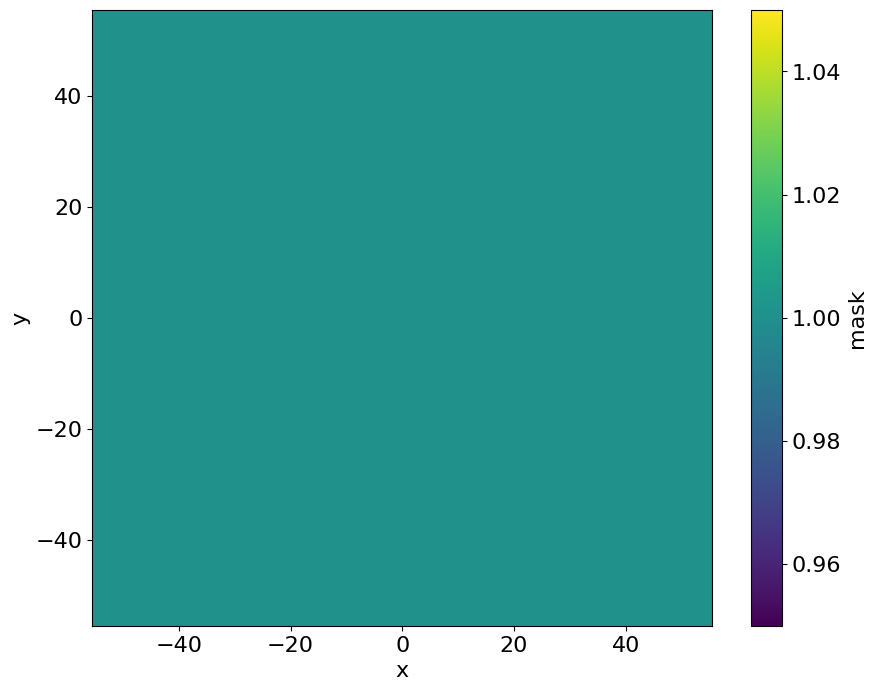

In [10]:
size = 111
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

The default settings for the for `LaPDXYExclusion` are the same as the manually constructed exclusion mask above.

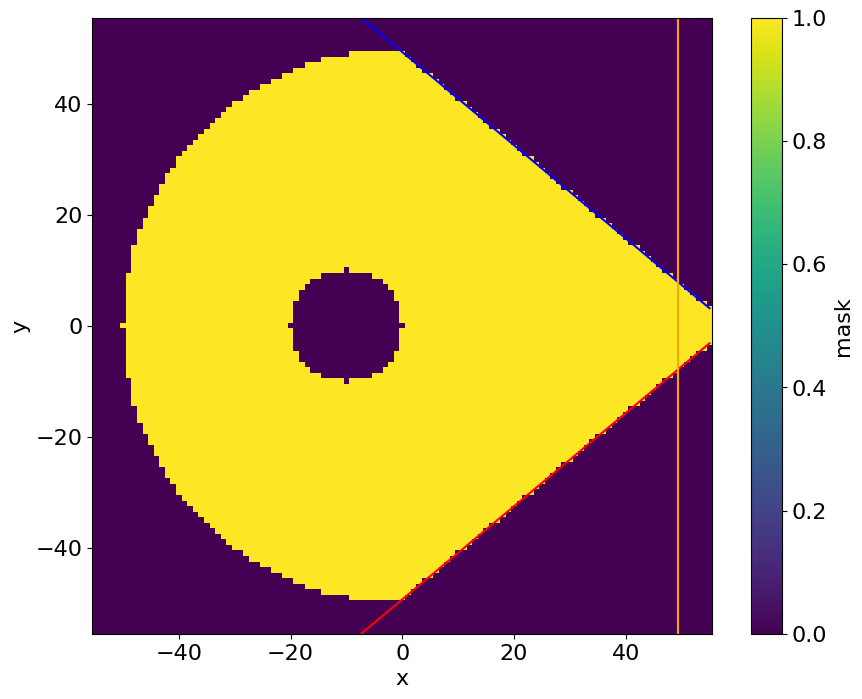

In [11]:
ex = LaPDXYExclusion(ds)
exC = CircularExclusion(ds, radius=10, center=(-10,0), exclude="inside")

ds.mask.plot(x="x", y="y")

colors = ["blue", "red", "orange"]
ii = 0
for subex in ex.composed_exclusions:
    if not isinstance(subex, DividerExclusion):
        continue

    (slope, intercept) = subex.mb
    color = colors[np.mod(ii, len(colors))]
    if np.isinf(slope):
        ylim = plt.gca().get_ylim()
        plt.vlines(intercept, *ylim, color=color)
    else:
        plt.plot(side, slope * side + intercept, color=color)

    ii += 1;

In [8]:
edge_pool = ex._build_edge_pool(ds.mask)

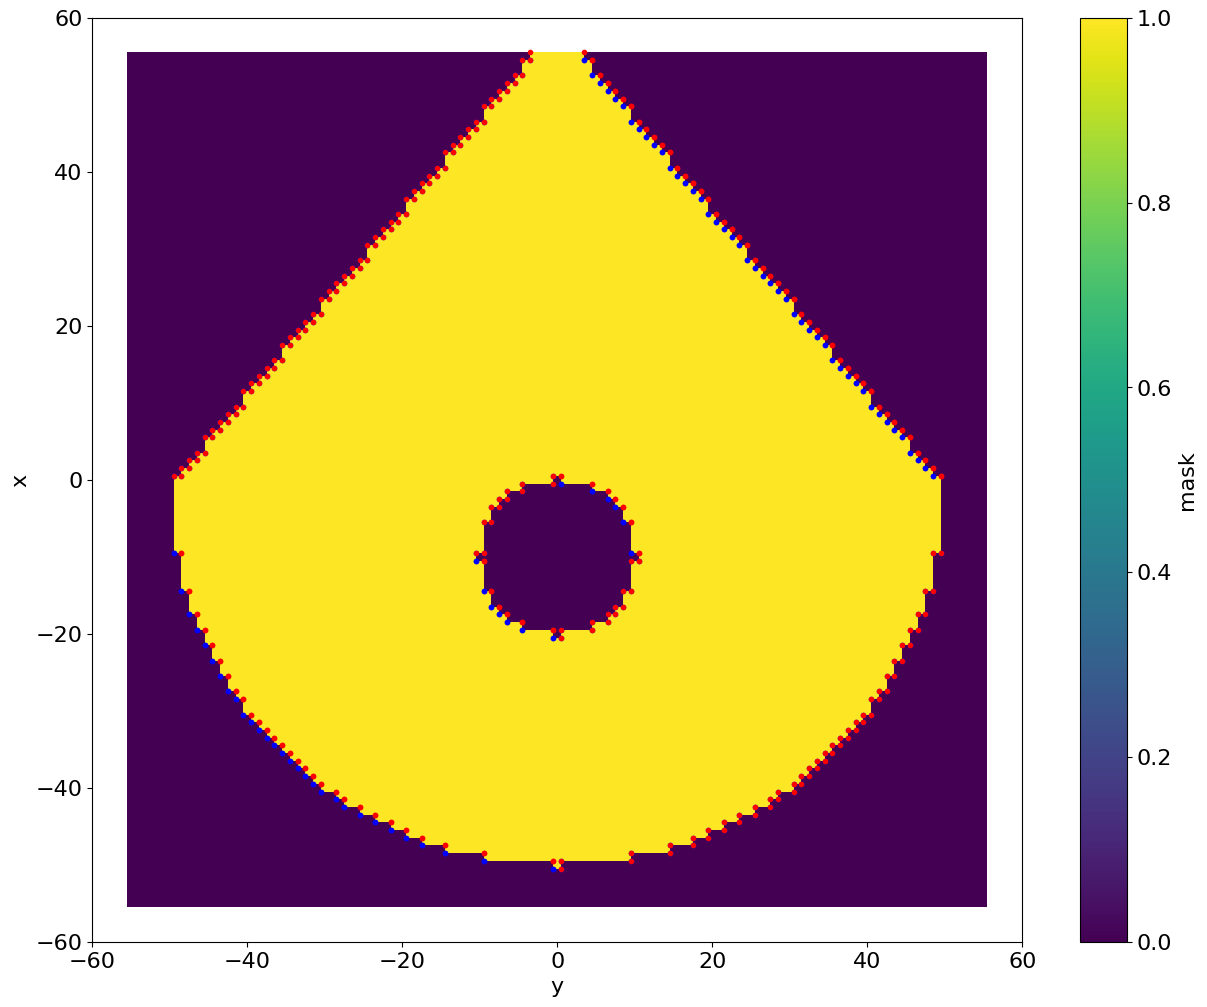

In [10]:
ds.mask.plot(aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(edge_pool[..., 0, 1], edge_pool[..., 0, 0], color="blue", s=3**2)
plt.scatter(edge_pool[..., 1, 1], edge_pool[..., 1, 0], color="red", s=3**2)

## Prototyping: Edge Finding

Useful links used to generate the shadowing algorithm:

- https://ncase.me/sight-and-light/
- https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect

In [12]:
from bapsf_motion.motion_builder.exclusions import LaPDXYExclusion, CircularExclusion

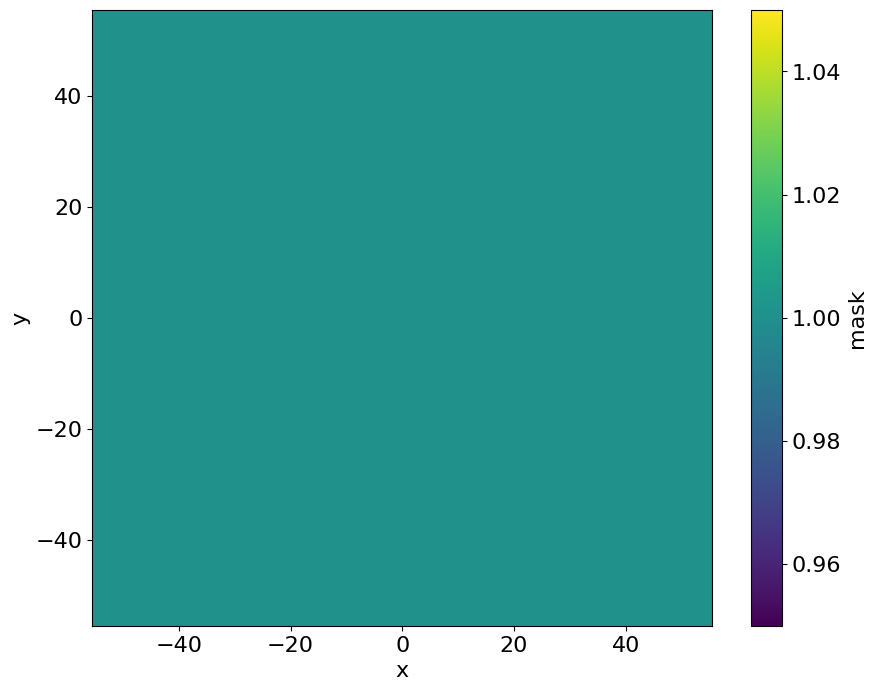

In [13]:
size = 111
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

The default settings for the for `LaPDXYExclusion` are the same as the manually constructed exclusion mask above.

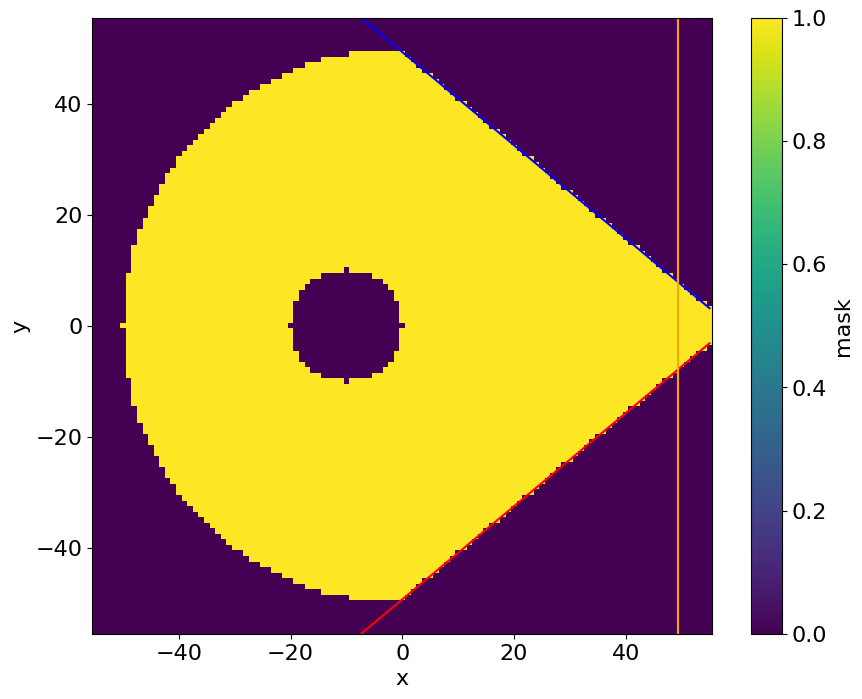

In [14]:
ex = LaPDXYExclusion(ds)
exC = CircularExclusion(ds, radius=10, center=(-10,0), exclude="inside")

ds.mask.plot(x="x", y="y")

colors = ["blue", "red", "orange"]
ii = 0
for subex in ex.composed_exclusions:
    if not isinstance(subex, DividerExclusion):
        continue

    (slope, intercept) = subex.mb
    color = colors[np.mod(ii, len(colors))]
    if np.isinf(slope):
        ylim = plt.gca().get_ylim()
        plt.vlines(intercept, *ylim, color=color)
    else:
        plt.plot(side, slope * side + intercept, color=color)

    ii += 1;

In [15]:
pool = ex._build_edge_pool(ds.mask)
pool.shape

(355, 2, 2)

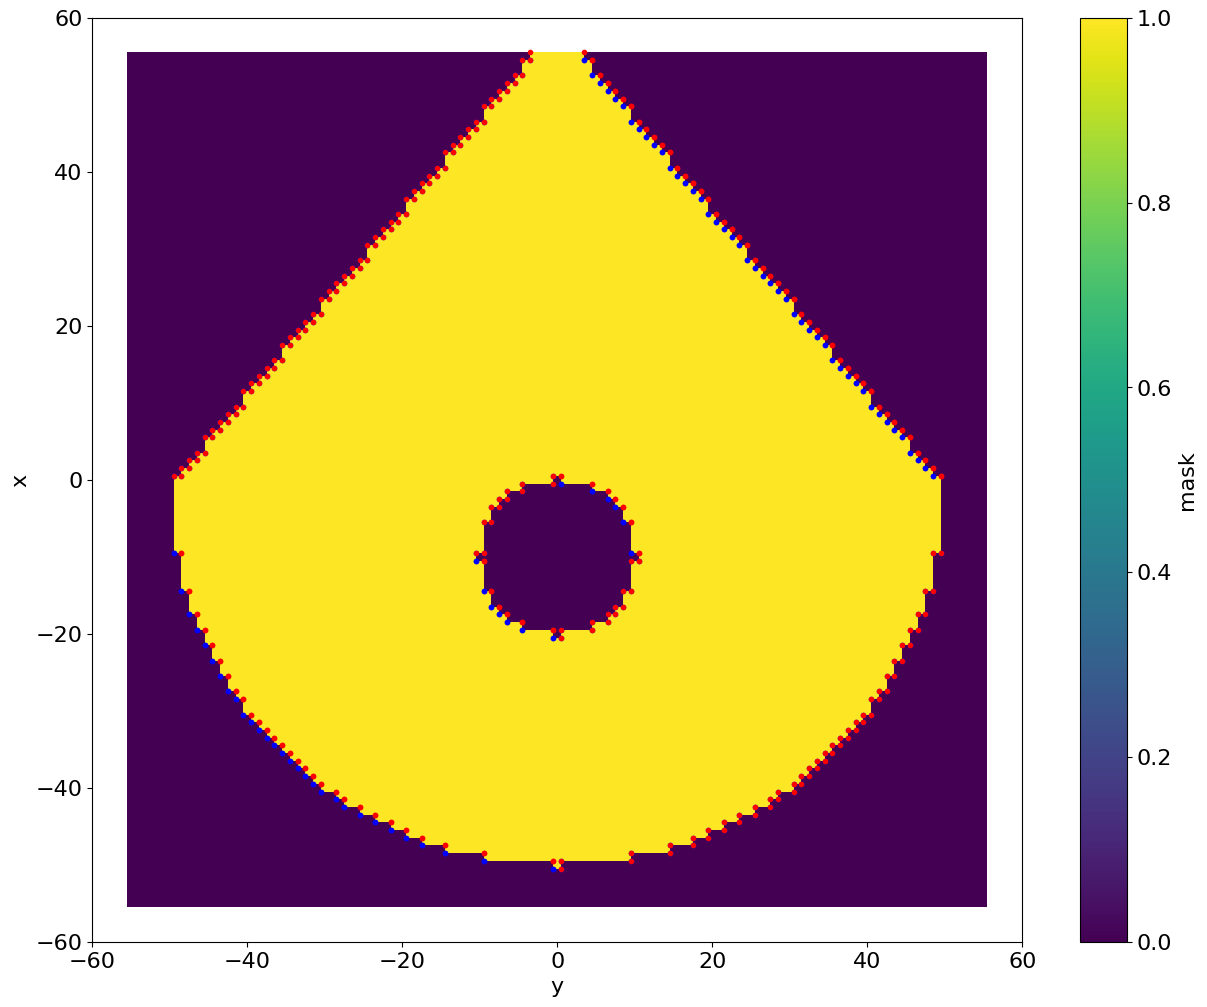

In [16]:
ds.mask.plot(aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(pool[..., 0, 1], pool[..., 0, 0], color="blue", s=3**2)
plt.scatter(pool[..., 1, 1], pool[..., 1, 0], color="red", s=3**2)

In [17]:
it = np.nditer(ds.mask, flags=["multi_index"])
for x in it:
    pass
    # print(it.multi_index)
type(x)

numpy.ndarray

In [18]:
mask_edges = xr.DataArray(
    data = -np.ones((size, size, 4), dtype=np.int32),
    coords = {**ds.coords, "edge": ["top", "right", "bottom", "left"]}
)

# mask_edges[ix, iy].loc["north"] = 5
# mask_edges[ix, iy].loc["north"]

In [19]:
mres = (
    np.average(np.diff(ds.x)),
    np.average(np.diff(ds.y)),
)
edge_pool = None

def add_to_edge_pool(edge, _pool):
    if _pool is None:
        _pool = np.array(edge)[np.newaxis, ...]
    else:
        _pool = np.concatenate(
            (_pool, np.array(edge)[np.newaxis, ...]),
            axis=0,
        )

    return _pool.shape[0] - 1, _pool

# edge_pool stores the actual edge information
# mask_edges stores the edge ID for each mask cell

for ix, row in enumerate(ds.mask):
    for iy, m in enumerate(row):
        # ix = np.where(ds.x == m.x)[0][0]
        # iy = np.where(ds.y == m.y)[0][0]
        index_top = (ix, iy+1)
        index_bottom = (ix, iy-1)
        index_right = (ix+1, iy)
        index_left = (ix-1, iy)

        if (
            bool(m)
            and (
                ix not in (0, size-1) 
                or iy not in (0, size-1)
            )
        ):
            # only find edges for exluded regions and mspace boundary
            # print(f"Continue ({ix}, {iy})")
            continue
        
        # Look at Bottom
        need_edge = (
            True
            if iy == 0 or bool(m != ds.mask[index_bottom])
            else False
        )
        
        if need_edge:
            if (
                ix == 0 
                or bool(m != ds.mask[index_left])
                or mask_edges[index_left].loc["bottom"] == -1
            ):
                # need new edge
                _edge = [
                    ds.x[ix] - 0.5 * mres[0],  # start x
                    ds.y[iy] - 0.5 * mres[1],  # start y
                    np.nan,  # stop x
                    np.nan,  # stop y
                ]
                eid, edge_pool = add_to_edge_pool(_edge, edge_pool)
            else:
                # continue existing edge
                eid  = mask_edges[index_left].loc["bottom"]

            mask_edges[ix, iy].loc["bottom"] = eid

            if (
                ix == size-1 
                or bool(m != ds.mask[index_right])
                or bool(m == ds.mask[index_right[0], index_bottom[1]])
            ):
                # edge ends
                edge_pool[eid, 2:] = [
                    ds.x[ix] + 0.5 * mres[0],  # stop x
                    ds.x[iy] - 0.5 * mres[1],  # stop y
                ]

        # Look at Top
        need_edge = (
            True
            if iy == size-1 or bool(m != ds.mask[index_top])
            else False
        )
        
        if need_edge:
            if (
                ix == 0 
                or bool(m != ds.mask[index_left])
                or mask_edges[index_left].loc["top"] == -1
            ):
                # need new edge
                _edge = [
                    ds.x[ix] - 0.5 * mres[0],  # start x
                    ds.y[iy] + 0.5 * mres[1],  # start y
                    np.nan,  # stop x
                    np.nan,  # stop y
                ]
                eid, edge_pool = add_to_edge_pool(_edge, edge_pool)
            else:
                # continue existing edge
                eid  = mask_edges[index_left].loc["top"]

            mask_edges[ix, iy].loc["top"] = eid

            if (
                ix == size-1 
                or bool(m != ds.mask[index_right])
                or bool(m == ds.mask[index_right[0], index_bottom[1]])
            ):
                # edge ends
                edge_pool[eid, 2:] = [
                    ds.x[ix] + 0.5 * mres[0],  # stop x
                    ds.x[iy] + 0.5 * mres[1],  # stop y
                ]

        # Look at Right
        need_edge = (
            True
            if ix == size-1 or bool(m != ds.mask[index_right])
            else False
        )
        
        if need_edge:
            if (
                iy == 0 
                or bool(m != ds.mask[index_bottom])
                or mask_edges[index_bottom].loc["right"] == -1
            ):
                # need new edge
                _edge = [
                    ds.x[ix] + 0.5 * mres[0],  # start x
                    ds.y[iy] - 0.5 * mres[1],  # start y
                    np.nan,  # stop x
                    np.nan,  # stop y
                ]
                eid, edge_pool = add_to_edge_pool(_edge, edge_pool)
            else:
                # continue existing edge
                eid  = mask_edges[index_bottom].loc["right"]

            mask_edges[ix, iy].loc["right"] = eid

            if (
                iy == size-1 
                or bool(m != ds.mask[index_top])
                or bool(m == ds.mask[index_top[0], index_right[1]])
            ):
                # edge ends
                edge_pool[eid, 2:] = [
                    ds.x[ix] + 0.5 * mres[0],  # stop x
                    ds.x[iy] + 0.5 * mres[1],  # stop y
                ]

        # Look at Left
        need_edge = (
            True
            if ix == 0 or bool(m != ds.mask[index_left])
            else False
        )
        
        if need_edge:
            if (
                iy == 0 
                or bool(m != ds.mask[index_bottom])
                or mask_edges[index_bottom].loc["left"] == -1
            ):
                # need new edge
                _edge = [
                    ds.x[ix] - 0.5 * mres[0],  # start x
                    ds.y[iy] - 0.5 * mres[1],  # start y
                    np.nan,  # stop x
                    np.nan,  # stop y
                ]
                eid, edge_pool = add_to_edge_pool(_edge, edge_pool)
            else:
                # continue existing edge
                eid  = mask_edges[index_bottom].loc["left"]

            mask_edges[ix, iy].loc["left"] = eid

            if (
                iy == size-1 
                or bool(m != ds.mask[index_top])
                or bool(m == ds.mask[index_top[0], index_right[1]])
            ):
                # edge ends
                edge_pool[eid, 2:] = [
                    ds.x[ix] - 0.5 * mres[0],  # stop x
                    ds.x[iy] + 0.5 * mres[1],  # stop y
                ]

edge_pool

array([[-55.5, -55.5,  55.5, -55.5],
       [-55.5, -55.5, -55.5,  55.5],
       [-55.5,  55.5,  55.5,  55.5],
       ...,
       [ 54.5,   3.5,  55.5,   3.5],
       [ 55.5,   3.5,  55.5,  55.5],
       [ 54.5,   3.5,  54.5,   4.5]])

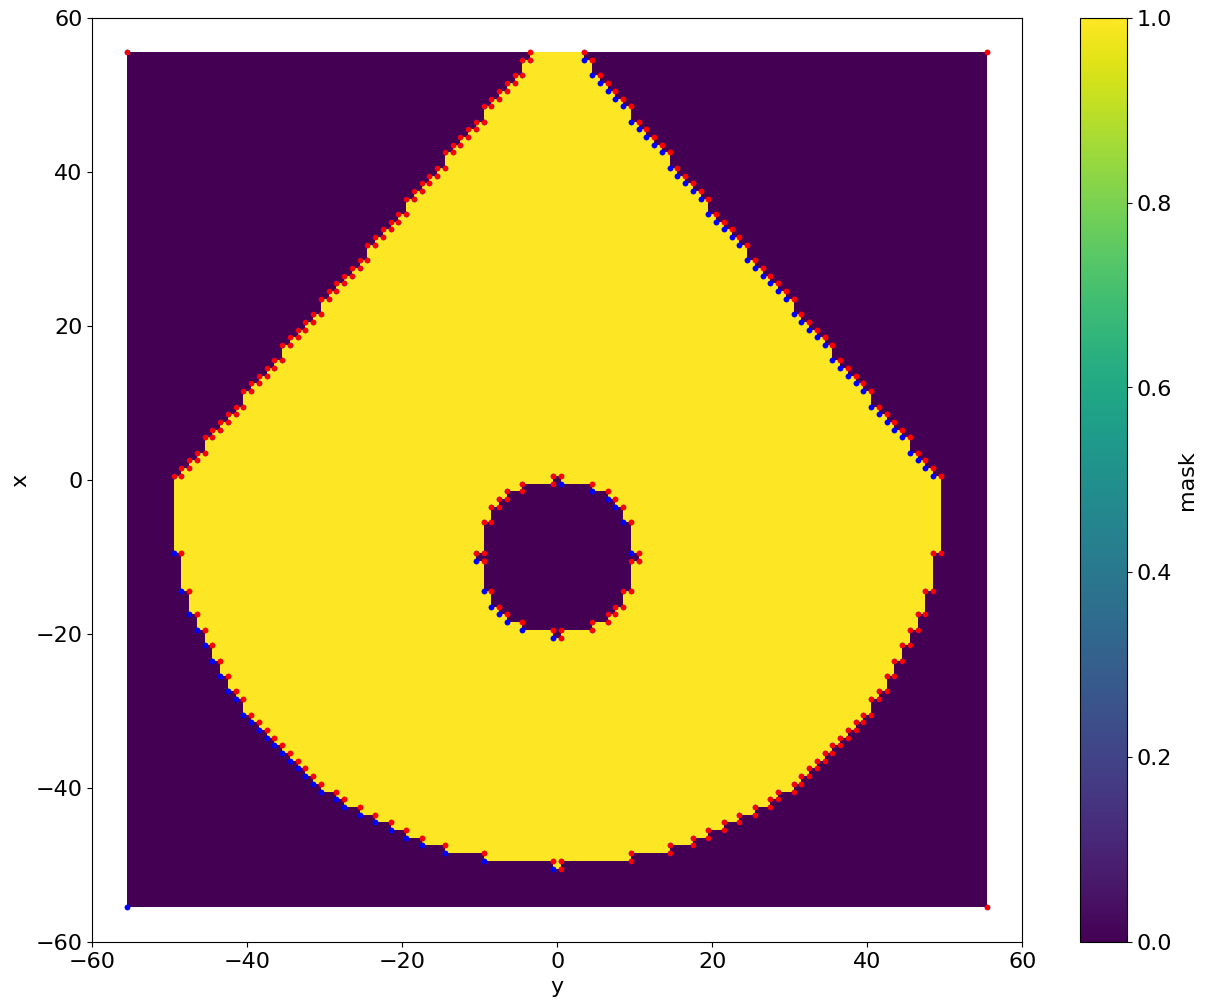

In [20]:
ds.mask.plot(aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(edge_pool[...,1], edge_pool[...,0], color="blue", s=3**2)
plt.scatter(edge_pool[...,3], edge_pool[...,2], color="red", s=3**2)

# lines = edge_pool.reshape(-1, 2, 2).reshape(-1, 2)
# plt.plot(*lines, c="k");
# plt.scatter(ds.x[0], ds.y[0])

# edge_points = edge_pool.reshape(-1, 2, 2).reshape(-1, 2)
# edge_points = np.unique(edge_points, axis=0)
# plt.scatter(edge_points[...,1], edge_points[..., 0])

In [21]:
def add_to_ep(edge, _pool):
    if _pool is None:
        _pool = np.array(edge)[np.newaxis, ...]
    else:
        _pool = np.concatenate(
            (_pool, np.array(edge)[np.newaxis, ...]),
            axis=0,
        )

    return _pool.shape[0] - 1, _pool

def build_edge_pool(_ds: xr.Dataset):
    # edge_pool.shape == (N, 2, 2)
    # index_1 == N == number of edges
    # index_2 == 2 == edge point 0 = start, 1 = stop
    # index_3 == 2 == coordingate (0, 1) = (x, y)

    mres = (
    np.average(np.diff(ds.x)),
    np.average(np.diff(ds.y)),
    )
    ep = None

    return ep

# vertical edges
vedge_indices = np.where(np.diff(ds.mask, axis=0))
xx = np.unique(vedge_indices[0])
# mask = vedge_indices[0] == 7
yy_mask = np.diff(vedge_indices[1]) !=  1
(
    xx,
    yy_mask,
)


ep = None
for ix in xx:
    _mask = vedge_indices[0] == ix
    yy = vedge_indices[1][_mask]

    x = ds.x[ix] + 0.5*mres[0]
    
    if yy.size == 1:
        iy = yy[0]
        edge = np.array(
            [
                [x, ds.y[iy] - 0.5*mres[1]],
                [x, ds.y[iy] + 0.5*mres[1]],
            ]
        )
        eid, ep = add_to_ep(edge, ep)
    else:
        
        jumps = np.where(np.diff(yy) != 1)[0]
        
        starts = np.array([0])
        starts = np.concatenate((starts, jumps+1))
        starts = yy[starts]
        
        stops = np.concatenate((jumps, [yy.size-1]))
        stops = yy[stops]

        for iy_start, iy_stop in zip(starts, stops):
            edge = np.array(
                [
                    [x, ds.y[iy_start] - 0.5*mres[1]],
                    [x, ds.y[iy_stop] + 0.5*mres[1]],
                ]
            )
            eid, ep = add_to_ep(edge, ep)

# horizontal edges
hedge_indices = np.where(np.diff(ds.mask, axis=1))
yy = np.unique(hedge_indices[1])
xx_mask = np.diff(hedge_indices[0]) !=  1

for iy in yy:
    _mask = hedge_indices[1] == iy
    xx = hedge_indices[0][_mask]

    y = ds.y[iy] + 0.5*mres[1]
    
    if xx.size == 1:
        ix = xx[0]
        edge = np.array(
            [
                [ds.x[ix] - 0.5*mres[0], y],
                [ds.x[ix] + 0.5*mres[0], y],
            ]
        )
        eid, ep = add_to_ep(edge, ep)
    else:
        
        jumps = np.where(np.diff(xx) != 1)[0]
        
        starts = np.array([0])
        starts = np.concatenate((starts, jumps+1))
        starts = xx[starts]
        
        stops = np.concatenate((jumps, [xx.size-1]))
        stops = xx[stops]

        for ix_start, ix_stop in zip(starts, stops):
            edge = np.array(
                [
                    [ds.x[ix_start] - 0.5*mres[0], y],
                    [ds.x[ix_stop] + 0.5*mres[0], y],
                ]
            )
            eid, ep = add_to_ep(edge, ep)

# TODO: add perimeter edges

# (
#     ep[0,0,:],
#     ep[0,1,:],
#     ep.shape
# )
ep = ep.reshape(-1, 4)
edge_pool = ep
# (
#     ep.shape,
#     edge_pool.shape
# )

In [22]:
edge_points = edge_pool.reshape(-1, 2, 2).reshape(-1, 2)
edge_points = np.unique(edge_points, axis=0)
edge_points.shape

(356, 2)

In [23]:
insertion_point = ex.insertion_point
insertion_point

array([58.771,  0.   ])

In [24]:
dy = (edge_points[..., 1] - insertion_point[1])
dx = (edge_points[..., 0] - insertion_point[0])

perp = np.where(dx == 0)[0]
if perp.size > 0:
    dy[perp] = np.inf * dy[perp] / np.abs(dy[perp])
    dx[perp] = 1.

ray_angles = np.arctan(dy / dx)

In [25]:
edge_points = np.concatenate(
    (edge_points, ray_angles[..., np.newaxis]),
    axis=1,
)
sort_i = np.argsort(edge_points[..., 2])
edge_points = edge_points[sort_i, ...]
edge_points.shape

(356, 3)

In [26]:
edge_vectors = edge_pool[..., 2:] - edge_pool[..., :2]
ray_vectors = edge_points[..., :2] - insertion_point
ray_vector = ray_vectors[0, ...]
(
    ray_vector,
    edge_vectors.shape,
)

(array([-3.271,  3.5  ]), (355, 2))

In [27]:
# mu_array = edge_pool[...,:2] - insertion_point
# mu_array = (
#     np.cross(edge_pool[...,:2] - insertion_point, edge_vectors) 
#     / np.cross(ray_vectors, edge_vectors)
# )
mu_array = (
    np.cross(edge_pool[...,:2] - insertion_point, edge_vectors) 
    / np.cross(ray_vectors, edge_vectors[:, np.newaxis, ...]).swapaxes(0, 1)
)
mu_array.shape

(356, 355)

In [28]:
# nu_array = (
#     np.cross(insertion_point - edge_pool[..., :2], ray_vectors)
#     / np.cross(edge_vectors, ray_vectors)
# )
nu_array = (
    np.cross((insertion_point - edge_pool[..., :2])[:, np.newaxis, ...], ray_vectors).swapaxes(0, 1)
    / np.cross(edge_vectors[:, np.newaxis, ...], ray_vectors).swapaxes(0, 1)
)
nu_array.shape

(356, 355)

In [29]:
c1 = mu_array > 0
c2 = mu_array < 1
c3 = nu_array >= 0
c4 = nu_array < 1

m1 = np.logical_and(c1, c2)
m2 = np.logical_and(c3, c4)
m3 = np.logical_and(m1, m2)
(
    np.count_nonzero(m1),
    np.count_nonzero(m2),
    np.count_nonzero(m3),
    m3.shape,
    np.count_nonzero(m3[50,...])
)


(46410, 9071, 6434, (356, 355), 76)

In [30]:
ii = 50

(
    ray_vectors[ii, ...],
    edge_points[ii, ...],
)

(array([-53.271,  44.5  ]), array([ 5.5       , 44.5       , -0.69592804]))

In [31]:
min_mu = np.min(mu_array[ii, m3[ii, ...]])
pt = insertion_point + min_mu * ray_vectors[ii, ...]

(
    min_mu,
    pt,
)

(0.07865168539325842, array([54.58114607,  3.5       ]))

In [32]:
adjusted_mu_array = np.nanmin(np.where(m3, mu_array, 1), axis=1)
end_pts = insertion_point + adjusted_mu_array[..., np.newaxis] * ray_vectors[...,:2]
# end_pts = np.unique(end_pts, axis=0)

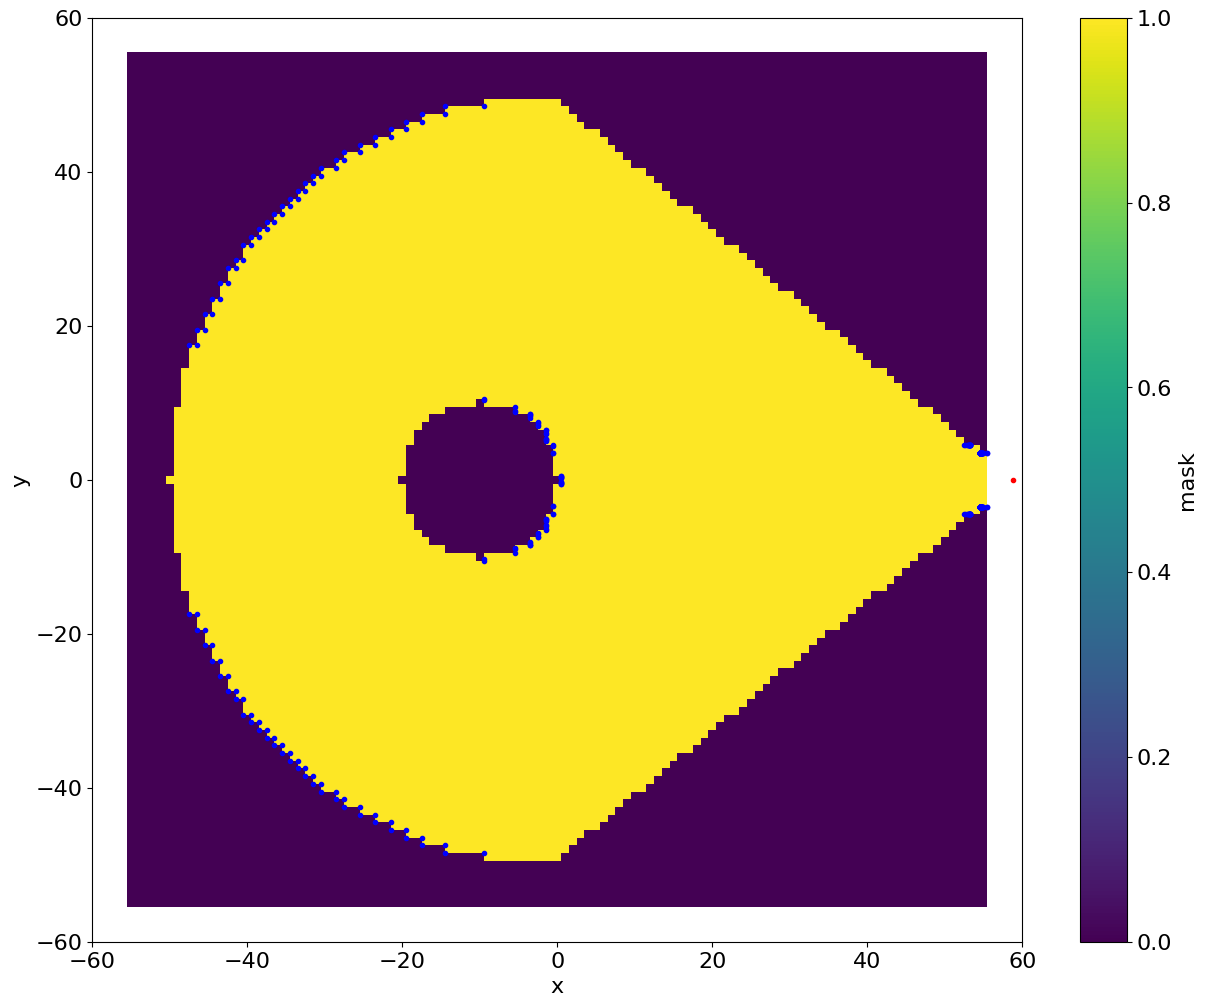

In [33]:
ds.mask.plot(x="x", y="y", aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(*insertion_point, color="red", s=3**2)
plt.scatter(end_pts[..., 0], end_pts[..., 1], color="blue", s=3**2)
# plt.scatter(edge_pool[...,3], edge_pool[...,2], color="red", s=3**2)

In [34]:
corner_mask = np.where(adjusted_mu_array == 1)[0]
# corner_pts = end_pts[corner_mask]
# corner_pts.shape
corner_rays = ray_vectors[corner_mask, ...]
# corner_ray_angles = edge_points[corner_mask, 2]
(
    corner_rays.shape,
    # corner_ray_angles.shape,
)

((124, 2),)

In [35]:
# corner_ray_angles

angles = np.arcsin(corner_rays[..., 1] / np.linalg.norm(corner_rays, axis=1))
corner_ray_angles = np.where(corner_rays[..., 0] >=0, angles, np.pi - angles)
# corner_ray_angles = angles
corner_ray_angles.shape

(124,)

In [36]:
fan_plus = np.linalg.norm(corner_rays, axis=1) * [np.cos(corner_ray_angles + .00001), np.sin(corner_ray_angles + .00001)]
fan_plus = fan_plus.swapaxes(0,1)

fan_minus = np.linalg.norm(corner_rays, axis=1) * [np.cos(corner_ray_angles - .00001), np.sin(corner_ray_angles - .00001)]
fan_minus = fan_minus.swapaxes(0,1)

fan_rays = np.concatenate(
    (fan_plus, fan_minus),
    axis=0,
)
(
    fan_plus.shape,
    fan_minus.shape,
    fan_rays.shape,
)

((124, 2), (124, 2), (248, 2))

In [37]:
mu_array = (
    np.cross(edge_pool[...,:2] - insertion_point, edge_vectors) 
    / np.cross(fan_rays, edge_vectors[:, np.newaxis, ...]).swapaxes(0, 1)
)
mu_array.shape

(248, 355)

In [38]:
mu_array[0,...]

array([ 33.40563461,  33.09992097,  33.09992097,  32.79420734,
        32.79420734,  32.4884937 ,  32.4884937 ,  32.18278007,
        32.18278007,  31.87706643,  31.87706643,  31.5713528 ,
        31.5713528 ,  31.26563916,  31.26563916,  30.95992553,
        30.95992553,  30.65421189,  30.65421189,  30.34849826,
        30.34849826,  30.04278462,  30.04278462,  29.73707099,
        29.73707099,  29.43135735,  29.43135735,  29.12564372,
        29.12564372,  28.81993008,  28.81993008,  28.51421645,
        28.51421645,  28.20850281,  28.20850281,  27.90278918,
        27.90278918,  27.59707554,  27.59707554,  27.29136191,
        27.29136191,  26.67993464,  26.67993464,  26.374221  ,
        26.374221  ,  25.76279373,  25.76279373,  25.15136646,
        25.15136646,  24.53993919,  24.53993919,  24.23422556,
        23.92851192,  23.92851192,  23.92851192,  23.92851192,
        23.62279829,  23.62279829,  23.31708465,  23.31708465,
        23.31708465,  23.31708465,  23.01137102,  23.01

In [39]:
nu_array = (
    np.cross((insertion_point - edge_pool[..., :2])[:, np.newaxis, ...], fan_rays).swapaxes(0, 1)
    / np.cross(edge_vectors[:, np.newaxis, ...], fan_rays).swapaxes(0, 1)
)
nu_array.shape

(248, 355)

In [40]:
c1 = mu_array > 0
# c2 = mu_array < 1
c3 = nu_array >= 0
c4 = nu_array < 1

# m1 = np.logical_and(c1, c2)
m2 = np.logical_and(c3, c4)
m3 = np.logical_and(c1, m2)
(
    np.count_nonzero(m1),
    np.count_nonzero(m2),
    np.count_nonzero(m3),
    m3.shape,
    np.count_nonzero(m3[1,...])
)


(46410, 466, 466, (248, 355), 35)

In [41]:
ii = 1
# m3[ii, ...]
mu_array[ii, m3[ii, ...]]

array([ 8.72645623,  7.32164452,  7.08750923,  6.15096809,  5.91683281,
        5.68269752,  4.74615638,  4.51202109,  4.27788581,  3.57547995,
        3.34134466,  3.10720938,  2.87307409,  2.17066823,  1.93653295,
        1.70239766,  1.46826238,  1.28572998,  1.57144775,  1.85716552,
        2.14288329,  2.71431884,  3.00003661,  3.28575438,  3.57147215,
        4.1429077 ,  4.42862547,  4.71434324,  5.57149656,  5.85721433,
        6.1429321 ,  7.00008542,  7.28580319,  8.71439206, 14.14302973])

In [42]:
adjusted_mu_array = np.nanmin(np.where(m3, mu_array, np.inf), axis=1)
fan_end_pts = insertion_point + adjusted_mu_array[..., np.newaxis] * fan_rays[...,:2]
# fan_end_pts = insertion_point - 1 * fan_rays[...,:2]
# fan_end_pts = insertion_point + fan_plus
inf_mask = np.logical_not(np.any(np.isinf(fan_end_pts), axis=1))

fan_end_pts = fan_end_pts[inf_mask, ...]
fan_end_pts.shape

(246, 2)

''

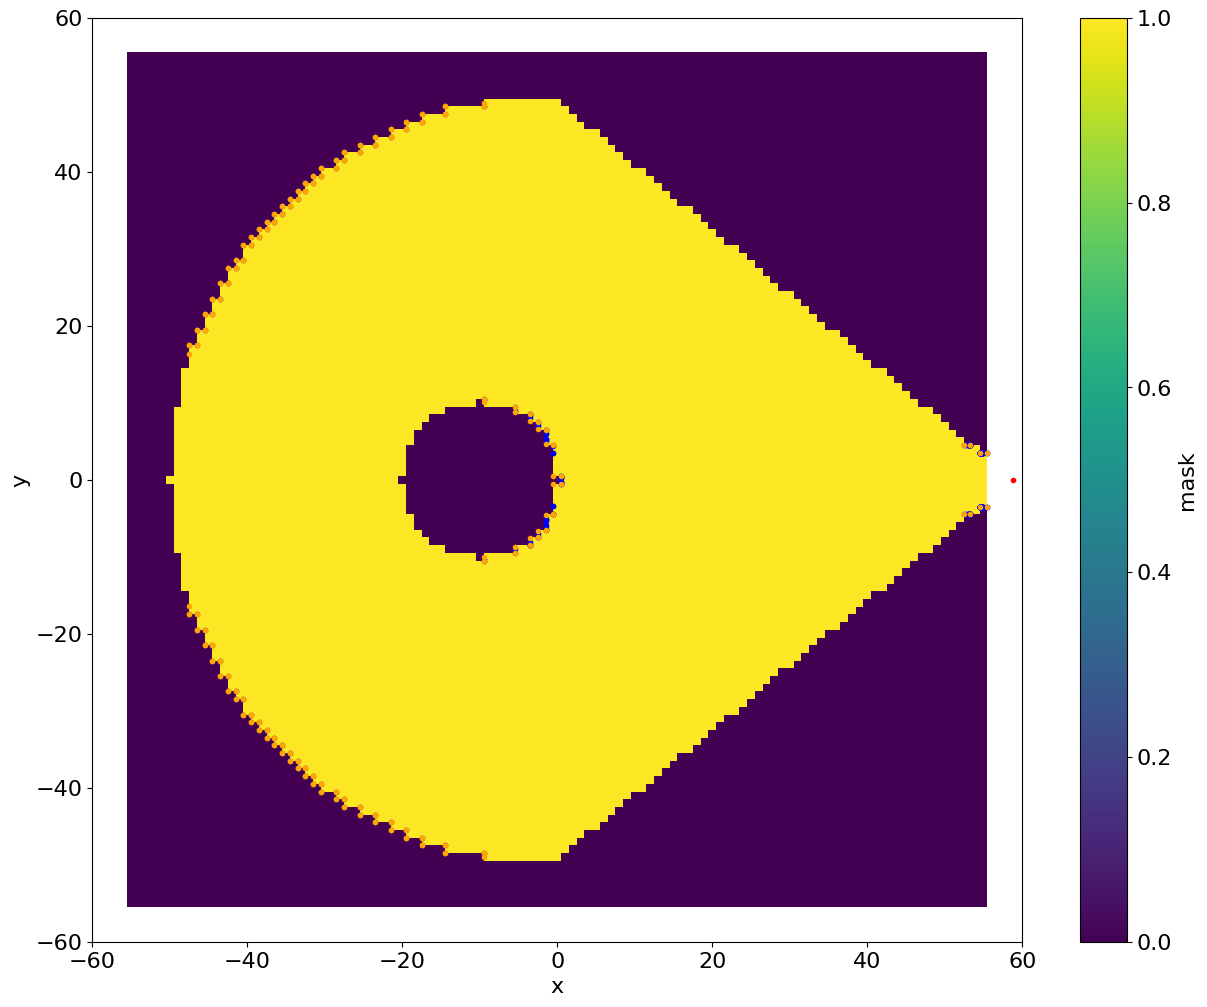

In [43]:
ds.mask.plot(x="x", y="y", aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(*insertion_point, color="red", s=3**2)
plt.scatter(end_pts[..., 0], end_pts[..., 1], color="blue", s=3**2)
plt.scatter(fan_end_pts[..., 0], fan_end_pts[..., 1], color="orange", s=3**2)
# plt.scatter(edge_pool[...,3], edge_pool[...,2], color="red", s=3**2)
;

In [44]:
# build triangles
all_end_pts = np.concatenate(
    (end_pts, fan_end_pts),
    axis=0,
)

def sort_array_by_angle(_arr, _ip):
    _arr2 = np.zeros_like(_arr)
    _arr2[..., 1] = _arr[..., 1] - _ip[1]
    _arr2[..., 0] = _arr[..., 0] - _ip[0]

    angles = np.arcsin(_arr2[..., 1] / np.linalg.norm(_arr2, axis=1))
    # andgles = np.arcsin(dy, np.linalg.norm([dx, dy], axis=0))
    
    sort_i = np.argsort(angles)
    return _arr[sort_i]

# angles = np.arcsin(all_end_pts[..., 1] / np.linalg.norm(all_end_pts, axis=1))
# angles = np.where(all_end_pts[..., 0] >0, angles, np.pi - angles)
# angles = np.arctan(all_end_pts[..., 1] / all_end_pts[..., 0])
# sort_i = np.argsort(angles)
# angles[sort_i]
# np.linalg.norm(all_end_pts, axis=1)
# np.any(np.isinf(fan_end_pts))
# all_end_pts = all_end_pts[sort_i]
all_end_pts = sort_array_by_angle(all_end_pts, insertion_point)
all_end_pts.shape

(602, 2)

In [45]:
def filter_close_points(_arr):
    _mask = np.all(
        np.isclose(
            all_end_pts,
            np.roll(all_end_pts, -1, axis=0),
            atol=.95*mres[0],
        ),
        axis=1,
    )
    _mask = np.roll(np.logical_not(_mask), 1)
    _mask[0] = True
    _mask[-1] = True

    return _arr[_mask, :]

# m_aep = np.all(np.isclose(all_end_pts, np.roll(all_end_pts, -1, axis=0), atol=.1*mres[0]), axis=1)
# m_aep = np.roll(np.logical_not(m_aep), 1)
# m_aep[0] = True
# m_aep[-1] = True

# all_end_pts = all_end_pts[m_aep, :]
all_end_pts = filter_close_points(all_end_pts)
all_end_pts = sort_array_by_angle(all_end_pts, insertion_point)
all_end_pts

array([[ 55.5       ,  -3.5       ],
       [ 53.27960227,  -4.5       ],
       [ -9.5       , -48.98947763],
       [-14.49840809, -48.5       ],
       [-14.5       , -47.50104065],
       [-17.49830034, -47.5       ],
       [-17.5       , -46.50104621],
       [-19.49821754, -46.5       ],
       [-19.5       , -45.50104721],
       [-21.49812889, -45.5       ],
       [-21.5       , -44.50104941],
       [-23.49803402, -44.5       ],
       [-23.5       , -43.50105272],
       [-25.49793249, -43.5       ],
       [-25.5       , -42.50105705],
       [-27.49782382, -42.5       ],
       [-27.5       , -41.50106235],
       [-28.49774981, -41.5       ],
       [-28.5       , -40.50106066],
       [-30.49762732, -40.5       ],
       [-30.5       , -39.50106749],
       [-31.49754206, -39.5       ],
       [-31.5       , -38.50106691],
       [-32.49745132, -38.5       ],
       [-32.5       , -37.50106679],
       [-33.49735468, -37.5       ],
       [-33.5       , -36.5010671 ],
 

In [46]:
_arr = all_end_pts
angles = np.arcsin(_arr[..., 1] / np.linalg.norm(_arr, axis=1))
angles

array([-0.06297966, -0.08426011, -1.37925447, -1.28031574, -1.27452409,
       -1.21783745, -1.21085522, -1.17374948, -1.16591287, -1.1294009 ,
       -1.12073178, -1.0849647 , -1.07549522, -1.04061593, -1.0303878 ,
       -0.99652759, -0.98559102, -0.96905734, -0.9576013 , -0.92536022,
       -0.91328115, -0.89763902, -0.8850804 , -0.86974355, -0.85671971,
       -0.84171593, -0.82824366, -0.8135995 , -0.79969794, -0.78543842,
       -0.77112891, -0.7572773 , -0.74258315, -0.72916072, -0.71410703,
       -0.70113287, -0.68574623, -0.67323707, -0.65754533, -0.64551545,
       -0.61322509, -0.60181871, -0.58523515, -0.57434781, -0.54043813,
       -0.53025947, -0.49533039, -0.48591047, -0.45009341, -0.4414738 ,
       -0.40491182, -0.39712453, -0.3599689 , -0.35303566, -0.33142211,
       -0.83535656, -1.04600056, -1.18018928, -1.24904577, -1.34399748,
       -1.46013911, -1.42694248, -0.79448788, -0.78539816,  0.79448788,
        1.42510687,  1.45828772,  1.25407073,  1.20913336,  1.14

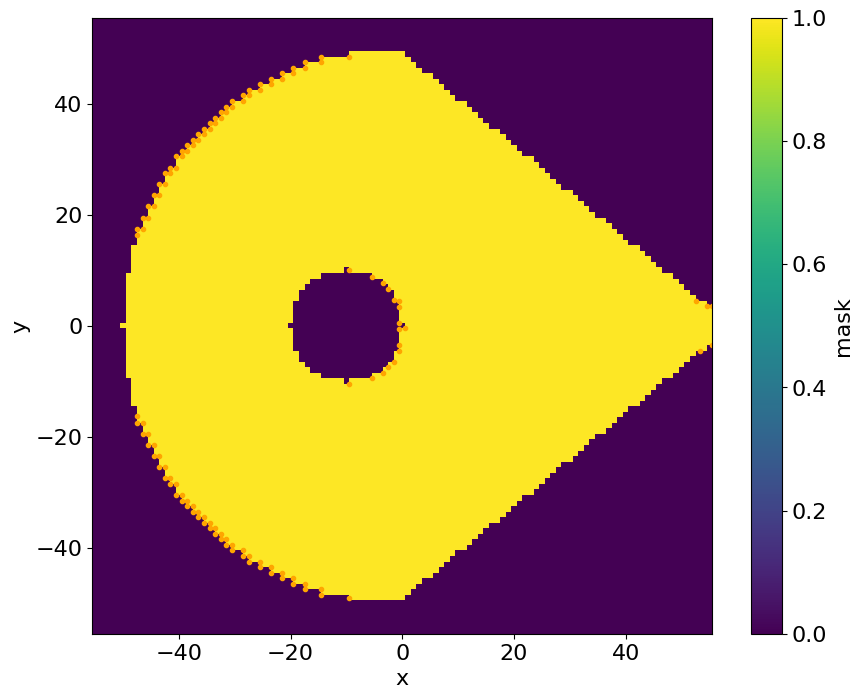

In [47]:
ds.mask.plot(x="x", y="y")
plt.scatter(all_end_pts[..., 0], all_end_pts[..., 1], color="orange", s=3**2);

In [48]:
triangles = np.zeros((all_end_pts.shape[0]-1, 3, 2))
triangles[..., 0, :] = insertion_point
triangles[..., 1, :] = all_end_pts[:-1,:]
triangles[..., 2, :] = all_end_pts[1:,:]
# triangles = triangles[48,...][np.newaxis, ...]
triangles.shape

(127, 3, 2)

In [49]:
all_pts = np.zeros((ds.x.size, ds.y.size, 2))
all_pts[..., 0] = np.repeat(ds.x.values[..., np.newaxis], ds.y.size, axis=1)
all_pts[..., 1] = np.repeat(ds.y.values[np.newaxis, ...], ds.x.size, axis=0)
# all_pts = all_pts.reshape(-1, 2)
all_pts.shape

(111, 111, 2)

In [50]:
# nom = (
#     np.cross(
#         all_pts[..., None, :],
#         triangles[None, None, :, 1, :] - triangles[None, None, :, 0, :]
#     )
#     - np.cross(triangles[:, 0, :], triangles[:, 1, :])[None, None, :]
# )
nom = np.cross(
    all_pts[:, :, None, :] - triangles[None, None, :, 0, :],
    (triangles[:, 1, :] - triangles[:, 0, :])[None, None, :, :],
)
# denom = np.cross(
#     triangles[..., 2, :] - triangles[..., 0, :],
#     triangles[..., 1, :] - triangles[..., 0, :],
# )
denom = np.cross(
    triangles[:, 2, :] - triangles[:, 0, :],
    triangles[:, 1, :] - triangles[:, 0, :]
)

lambda_3 = nom / denom[None, None, ...]

(
    nom.shape,
    denom.shape,
    lambda_3.shape,
    all_pts.shape,
)

((111, 111, 127), (127,), (111, 111, 127), (111, 111, 2))

In [51]:
ml3_1 = lambda_3 >= 0
ml3_2 = lambda_3 < 1
ml3 = np.logical_and(ml3_1, ml3_2)
np.count_nonzero(ml3)

13124

In [52]:
# nom = all_pts[:, :, None, :] - triangles[None, None, :, 0, :] - (triangles[:, 2, :] - triangles[:, 0, :])[None, None, :, :] * lambda_3[:, :, :, None]
# denom = triangles[:, 1, :] - triangles[:, 0, :]

nom  = np.cross(
    all_pts[:, :, None, :] - triangles[None, None, :, 0, :],
    (triangles[:, 2, :] - triangles[:, 0, :])[None, None, :, :],
)
denom = np.cross(
    triangles[:, 1, :] - triangles[:, 0, :],
    triangles[:, 2, :] - triangles[:, 0, :]
)

lambda_2 = nom / denom[None, None, :]

(
    nom.shape,
    denom.shape,
    lambda_2.shape,
)

((111, 111, 127), (127,), (111, 111, 127))

In [53]:
ml2_1 = lambda_2 >= 0
ml2_2 = lambda_2 <= 1
ml2 = np.logical_and(ml2_1, ml2_2)
np.count_nonzero(ml2)

12679

In [54]:
ml4 = lambda_2 + lambda_3 < 1
ml_ = np.logical_and(ml2, ml3)
ml_ = np.logical_and(ml4, ml_)
ml = np.any(ml_, axis=2)
(
    ml_.shape,
    ml.shape,
    np.count_nonzero(ml),
)

((111, 111, 127), (111, 111), 5112)

In [55]:
triangles[0,...,:]

array([[58.771     ,  0.        ],
       [55.5       , -3.5       ],
       [53.27960227, -4.5       ]])

[[58.771  0.   ]
 [54.5    3.5  ]
 [55.5    3.5  ]]


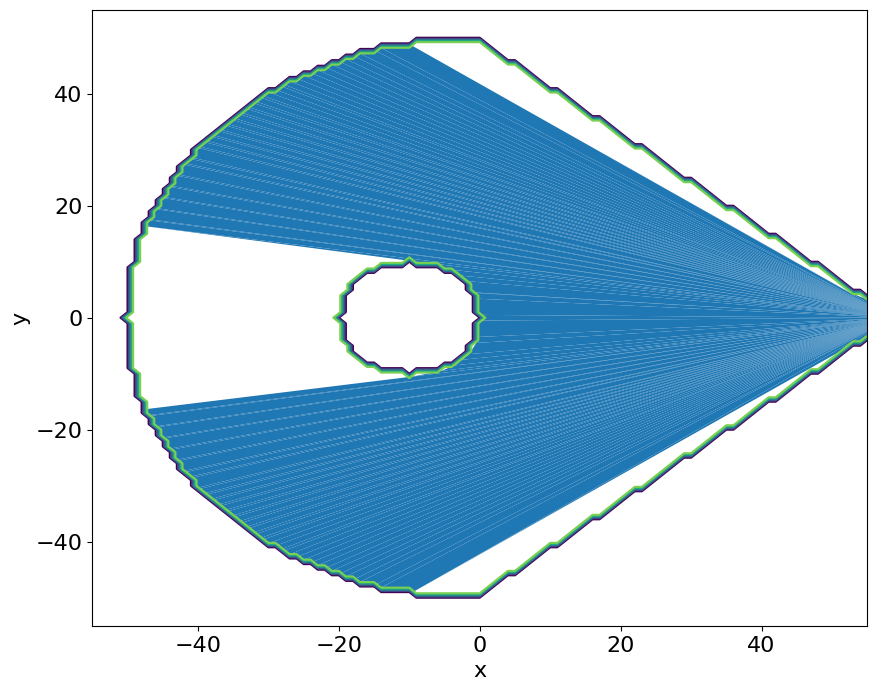

In [56]:
# itri = 0

ds.mask.plot.contour(x="x", y="y")
# plt.plot(triangles[itri,...,0], triangles[itri,...,1])
ax = plt.gca()
for itri in range(triangles.shape[0]):
    ax.add_patch(Polygon(triangles[itri, ...]))

print(triangles[itri,...])

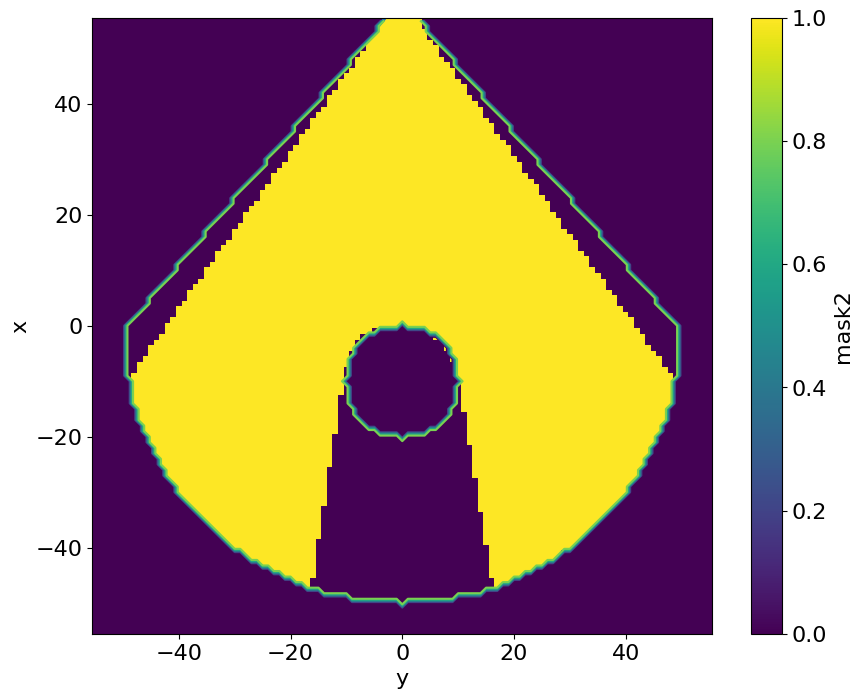

In [563]:
ds["mask2"] = ds.mask.copy()
ds["ml_"] = ds.mask.copy()

ds.mask2[...] = ml[...]
ds.ml_[...] = ml_[..., 0]
# ds.ml_[...] = ml3[..., 0]
# ds.ml_[...] = (lambda_2 + lambda_3 < 1)[..., 0]


# ds.mask.plot()
ds.mask2.plot()
# ds.ml_.plot()
ds.mask.plot.contour()

ax = plt.gca()
ax.add_patch(Polygon(np.flip(triangles[0,...], axis=1)))

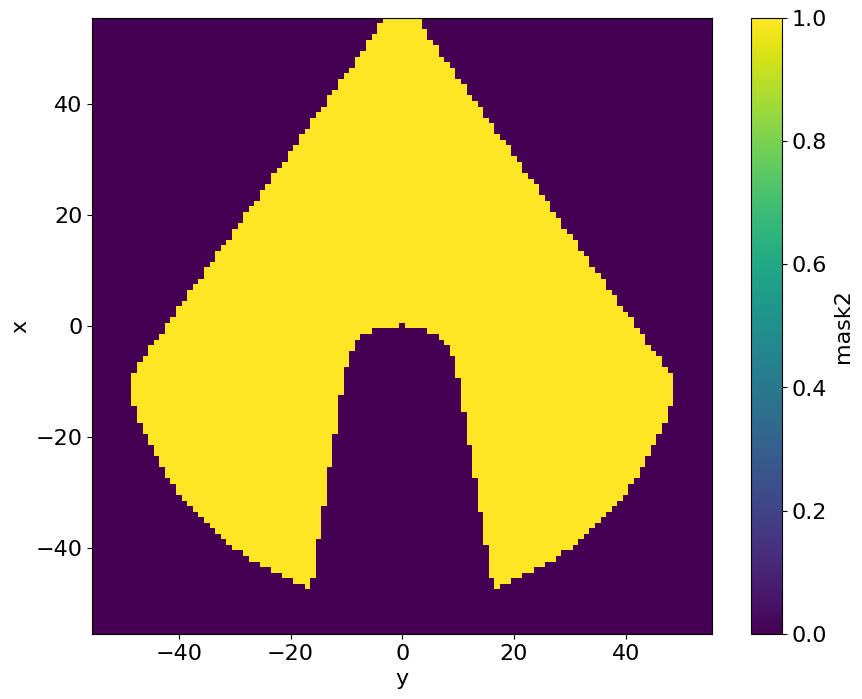

In [564]:
ds.mask2[...] = np.logical_and(ds.mask2.values, ds.mask.values)
ds.mask2.plot()

### Random Proto

In [234]:
num = np.cross(edge_pool[...,:2] - insertion_point, edge_vectors)
denum = np.cross(ray_vectors, edge_vectors[:, np.newaxis, ...]).swapaxes(0,1)
mu2d = (num/denum)
(
    num.shape,
    denum.shape,
    mu2d.shape,
)

((360,), (360, 360), (360, 360))

In [238]:
smua = (
    np.cross(edge_pool[...,:2] - insertion_point, edge_vectors) 
    / np.cross(ray_vectors[1,...], edge_vectors)
)
np.all(smua == mu2d[1, ...])

True

In [263]:
num = np.cross((insertion_point - edge_pool[..., :2])[:, np.newaxis, ...], ray_vectors).swapaxes(0, 1)
denum = np.cross(edge_vectors[:, np.newaxis, ...], ray_vectors).swapaxes(0, 1)
nu2d = (num/denum)
(
    num.shape,
    denum.shape,
    nu2d.shape,
)

((360, 360), (360, 360), (360, 360))

In [267]:
ii = 33
# np.all(num[ii, ...] == np.cross(insertion_point - edge_pool[..., :2], ray_vectors[ii, ...]))
# np.all(denum[ii, ...] == np.cross(edge_vectors, ray_vectors[ii, ...]))
# np.all(num[ii, ...] / denum[ii, ...] == np.cross(insertion_point - edge_pool[..., :2], ray_vectors[ii, ...]) / np.cross(edge_vectors, ray_vectors[ii, ...]))
np.all(nu2d[ii, ...] == np.cross(insertion_point - edge_pool[..., :2], ray_vectors[ii, ...]) / np.cross(edge_vectors, ray_vectors[ii, ...]))


True

In [89]:
edge_points[2, ...]

array([-50.5,  -0.5])

In [95]:
edge_pool[109,...]

array([-20.5,  -0.5, -20.5,   0.5])

In [101]:
np.where(np.all(edge_pool[...,:2] == edge_points[2,...], axis=1))

(array([3, 5], dtype=int64),)

In [105]:
np.arctan(1/0)

ZeroDivisionError: division by zero

In [104]:
np.pi/2

1.5707963267948966

In [112]:
np.where(dx == 0)[0].size > 0

False

In [114]:
-1*np.inf

-inf